In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
import math
import pickle

# Load your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

## Construct the repeating part of the circuit

In [2]:
# Set the state we wish to search 
N = '0110'
num_qubits = len(N)

# Create the quantum circuit 
qc = QuantumCircuit(num_qubits)

qc.barrier()

#Draw the circuit
qc.draw()

░ 
q_0: ─░─
      ░ 
q_1: ─░─
      ░ 
q_2: ─░─
      ░ 
q_3: ─░─
      ░

In [3]:
# Create custom cx gate with multiple controls
from qiskit.circuit.library.standard_gates import XGate

multi_cx_gate = XGate().control(num_qubits-1)

In [4]:
# Reverse the state so it’s in proper qubit ordering
N = N[::-1]

# Encode N into our circuit
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw()

░ ┌───┐ ░ 
q_0: ─░─┤ X ├─░─
      ░ └───┘ ░ 
q_1: ─░───────░─
      ░       ░ 
q_2: ─░───────░─
      ░ ┌───┐ ░ 
q_3: ─░─┤ X ├─░─
      ░ └───┘ ░

In [5]:
# Create the Grover oracle for our quantum circuit
qc.h(num_qubits-1)
qc.append(multi_cx_gate, range(num_qubits))

qc.h(num_qubits-1)
qc.barrier()

# Draw the circuit
qc.draw()

░ ┌───┐ ░                 ░ 
q_0: ─░─┤ X ├─░────────■────────░─
      ░ └───┘ ░        │        ░ 
q_1: ─░───────░────────■────────░─
      ░       ░        │        ░ 
q_2: ─░───────░────────■────────░─
      ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ 
q_3: ─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─
      ░ └───┘ ░ └───┘└───┘└───┘ ░

In [6]:
# Reset the value after the oracle
for idx in range(num_qubits):
    if N[idx] == '0':
        qc.x(idx)
qc.barrier()

# Draw the circuit
qc.draw()


░ ┌───┐ ░                 ░ ┌───┐ ░ 
q_0: ─░─┤ X ├─░────────■────────░─┤ X ├─░─
      ░ └───┘ ░        │        ░ └───┘ ░ 
q_1: ─░───────░────────■────────░───────░─
      ░       ░        │        ░       ░ 
q_2: ─░───────░────────■────────░───────░─
      ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ 
q_3: ─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─
      ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░

In [7]:
# Set all qubits in superposition
qc.h(range(num_qubits))
qc.x(range(num_qubits))
qc.barrier()

# Draw the circuit
qc.draw()

░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐┌───┐ ░ 
q_0: ─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├┤ X ├─░─
      ░ └───┘ ░        │        ░ └───┘ ░ ├───┤├───┤ ░ 
q_1: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░─
      ░       ░        │        ░       ░ ├───┤├───┤ ░ 
q_2: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░─
      ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ ├───┤├───┤ ░ 
q_3: ─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├─░─
      ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘└───┘ ░

In [8]:
# Apply another oracle, same as the previous, 
qc.h(num_qubits-1)

qc.append(multi_cx_gate, range(num_qubits))
qc.h(num_qubits-1)
qc.barrier()

# Draw the circuit
qc.draw()

░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐┌───┐ ░                 ░ 
q_0: ─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├┤ X ├─░────────■────────░─
      ░ └───┘ ░        │        ░ └───┘ ░ ├───┤├───┤ ░        │        ░ 
q_1: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░────────■────────░─
      ░       ░        │        ░       ░ ├───┤├───┤ ░        │        ░ 
q_2: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░────────■────────░─
      ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ ├───┤├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ 
q_3: ─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─
      ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘└───┘ ░ └───┘└───┘└───┘ ░

In [9]:
# Reapply the X rotations on all qubits
qc.x(range(num_qubits))

qc.barrier()

# Draw the circuit
qc.draw()

░ ┌───┐ ░                 ░ ┌───┐ ░ ┌───┐┌───┐ ░                 ░ ┌───┐»
q_0: ─░─┤ X ├─░────────■────────░─┤ X ├─░─┤ H ├┤ X ├─░────────■────────░─┤ X ├»
      ░ └───┘ ░        │        ░ └───┘ ░ ├───┤├───┤ ░        │        ░ ├───┤»
q_1: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░────────■────────░─┤ X ├»
      ░       ░        │        ░       ░ ├───┤├───┤ ░        │        ░ ├───┤»
q_2: ─░───────░────────■────────░───────░─┤ H ├┤ X ├─░────────■────────░─┤ X ├»
      ░ ┌───┐ ░ ┌───┐┌─┴─┐┌───┐ ░ ┌───┐ ░ ├───┤├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤»
q_3: ─░─┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├─░─┤ H ├┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├»
      ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘ ░ └───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘»
«      ░ 
«q_0: ─░─
«      ░ 
«q_1: ─░─
«      ░ 
«q_2: ─░─
«      ░ 
«q_3: ─░─
«      ░

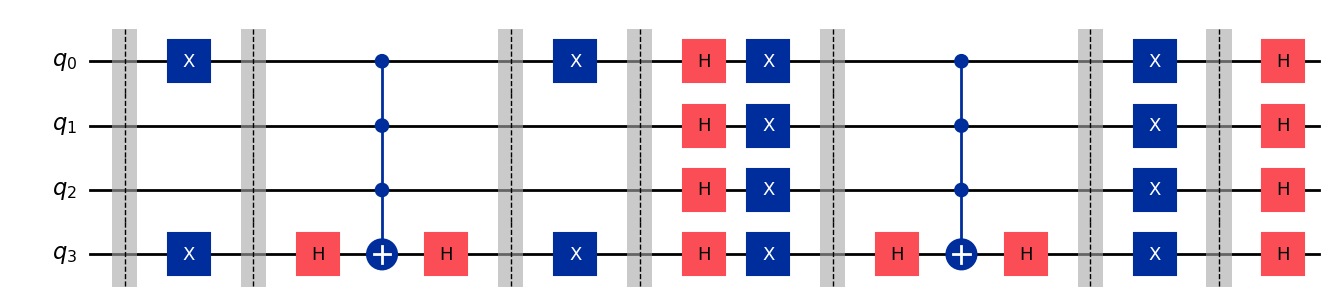

In [10]:
# repeat v2^n times to solidify the result

repeat_times = int(math.sqrt(2**num_qubits))

# treat the whole circuit as a composite circuit
qc.h(range(num_qubits))
composite = qc.to_instruction()

# Draw the circuit
qc.draw("mpl").savefig('results/grover_repetition.jpg')
qc.draw("mpl")

## Create the Grover circuit with the repetitions

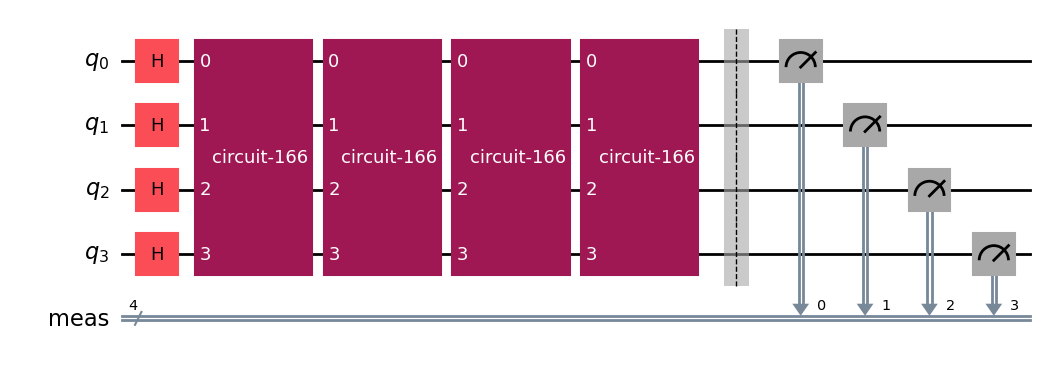

In [11]:
qc_whole = QuantumCircuit(num_qubits)
qc_whole.h(range(num_qubits))
qc_whole.append(composite, range(num_qubits))

# plug the composite (repeat_times - 1) times to the main circuit
for i in range(repeat_times-1):
    qc_whole.append(composite, range(num_qubits))

# Add measurement operators
qc_whole.measure_all()

# Draw the circuit
qc_whole.draw("mpl").savefig('results/grover_circuit.jpg')
qc_whole.draw("mpl")

## Run Grover's algorithm circuit on simulated backend without noise

{'0110': 2380, '0001': 104, '1010': 119, '1101': 108, '0100': 105, '0011': 127, '1110': 97, '1000': 115, '0111': 119, '1011': 117, '1100': 106, '0010': 128, '0101': 98, '0000': 121, '1111': 128, '1001': 124}


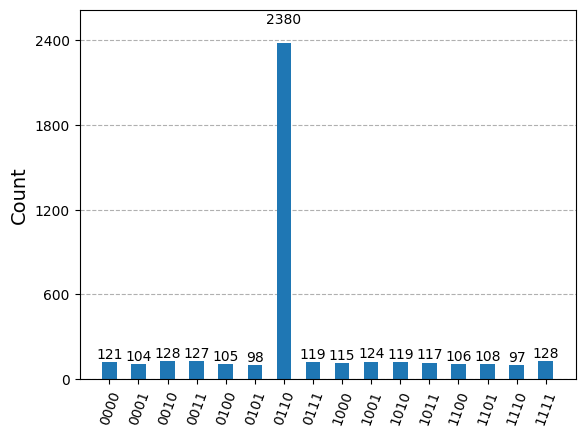

In [12]:
# Run on the qasm simulator
simulator = AerSimulator()
circ = transpile(qc_whole, simulator)
result = simulator.run(circ, shots = 4096).result()
counts = result.get_counts(circ)

# Print and plot results
print(counts)
plot_histogram(counts).savefig('results/grover_ideal.jpg')
plot_histogram(counts)

## Run Grover's algorithm circuit on simulated backend with noise model (locally)

{'0010': 245, '1011': 182, '1100': 236, '1110': 257, '1111': 200, '0110': 508, '1001': 184, '0111': 337, '0001': 189, '1000': 210, '1101': 234, '0101': 317, '0100': 315, '0000': 227, '1010': 225, '0011': 230}


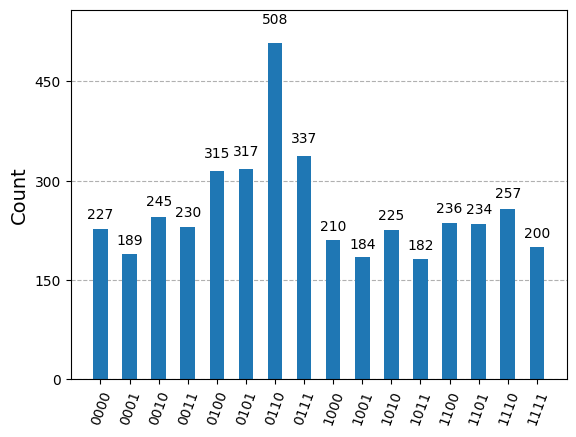

In [13]:
# Simulate a noisy backend, based on a cloud backend
backend = service.backend("ibm_sherbrooke")
sim_sherbrooke = AerSimulator.from_backend(backend)

# Transpile the circuit for the noisy basis gates
tcirc = transpile(circ, sim_sherbrooke)

# Execute the circuit on the simulated noisy backend and plot results
result_noise = sim_sherbrooke.run(tcirc, shots = 4096).result()
counts_noise = result_noise.get_counts(0)
print(counts_noise)
plot_histogram(counts_noise).savefig('results/grover_noise_local.jpg')
plot_histogram(counts_noise)

## Run Grover's algorithm circuit on actual quantum hardware

In [15]:
# Transpile the circuit for the selected backend
backend_name = "ibm_sherbrooke"
backend = service.backend(backend_name)  # Example using a simulator
transpiled_circuit = transpile(qc_whole, backend)

# # Execute the circuit
# job = backend.run(transpiled_circuit, shots = 4096)

# Define Sampler
sampler = Sampler(mode=backend)
 
# Run calculation
job = sampler.run([transpiled_circuit], shots=4096)

# Save the job ID
job_id = job.job_id()

print(f"Job (ID: {job_id}) sent successfully to backend {backend_name}.")
print("Come back after a few hours and retrieve the results with the cell below.")

Job (ID: cw6ydny2802g00819cgg) sent successfully to backend ibm_sherbrooke.
Come back after a few hours and retrieve the results with the cell below.


### Retrieve job result from the cloud, based on job ID

Results:
{'0011': 235, '1101': 236, '1100': 250, '0010': 306, '1011': 205, '1110': 280, '0110': 420, '1111': 190, '1010': 208, '0101': 232, '0100': 322, '0111': 300, '0001': 232, '0000': 237, '1001': 231, '1000': 212}


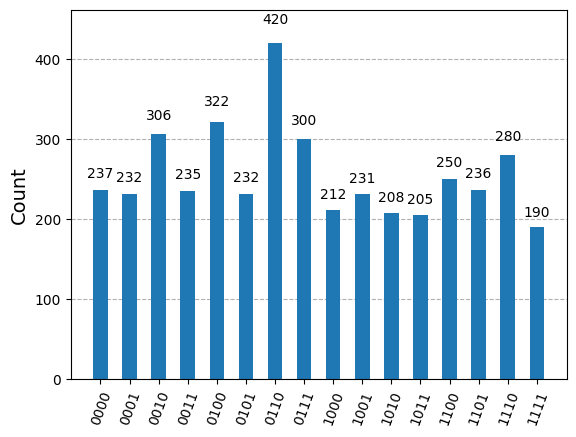

In [17]:
# Monitor the job status on IQP, and run this cell when the sent job has been completed

# Reload the service object, in case the nb starts up fresh
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum")

# Retrieve the job result based on its ID
retrieved_job = service.job('cw6ydny2802g00819cgg') # Put the job ID from the above cell here
job_result = retrieved_job.result()

# Print and plot results
print("Results:")
counts_cloud = job_result[0].data.meas.get_counts()
print(counts_cloud)
plot_histogram(counts_cloud).savefig("results/grover_noise_sherbrooke.jpg")
plot_histogram(counts_cloud)